# Vision Transformer (ViT) -Finetune
In this notebook you will finetune a pretrained Vision Transformer for a downstream task.
Models pretrained on large datasets are also called Foundation models, since they can be used for many different tasks.

**Dataset**
- Pretrained model was trained on : Imagenet 14'197'122 images - 1000 Classes. 
- Finetune on CIFAR 10 You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")


**Content**
1.   Load a pretrained VisionTransfomer model
3.   Finetune the model on CIFAR 10

Imagenet: https://www.image-net.org/about.php
VisionTransformer: https://arxiv.org/abs/2010.11929


-------

In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# Configuration
model_name = "vit_base_patch16_224"
batch_size = 64
epochs = 10
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


### 1. Data Preparation

# Data Augmentation and Normalization
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize CIFAR-10 images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset, already included in torchvision 
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)



# training fucntion 
def train(model, loader, optimizer, criterion, device,n_batches=None):
    model.train()      # Set the model to training mode 
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, targets) # Calculate the loss
        loss.backward() # Backward pass
        optimizer.step() # Update the weights
        
        running_loss += loss.item() # Accumulate the loss
        _, predicted = outputs.max(1) # Get the predicted class
        correct += predicted.eq(targets).sum().item() # Compare with the ground truth
        total += targets.size(0) # Accumulate the number of samples
        

        # Print a message after each batch
        print(f"Batch {batch_idx + 1}/{len(loader)} completed.")
        if n_batches == batch_idx:
            break
    
    acc = 100. * correct / total # Calculate the accuracy
    print(f"Train Loss: {running_loss/len(loader):.4f}, Accuracy: {acc:.2f}%") 
    return running_loss / len(loader), acc

# Testing Function
def test(model, loader, criterion, device):
    model.eval() # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    outputs_list = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, targets) # Calculate the loss
            
            outputs_list.append(outputs) # Save the outputs for visualization
            
            test_loss += loss.item() 
            _, predicted = outputs.max(1) # Get the predicted class
            
            
            correct += predicted.eq(targets).sum().item() # Compare with the ground truth
            total += targets.size(0) 
    
    acc = 100. * correct / total # Calculate the accuracy
    print(f"Test Loss: {test_loss/len(loader):.4f}, Accuracy: {acc:.2f}%")
    return test_loss / len(loader), acc , outputs_list

Device: cuda
Files already downloaded and verified
Files already downloaded and verified


lets check the label distribution on the test set:
- you can see that the testset consists of 1000 images per class.

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

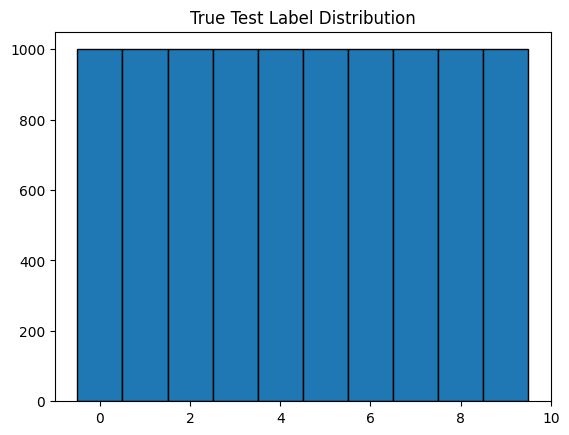

In [3]:
y_true=list(test_dataset.targets)
plt.title("True Test Label Distribution")
plt.hist(y_true,np.arange(0,11), edgecolor='black', align='left')

Ok lets now check what the model outputs when its not finetuned on the task
- what do you expect? 
- note that the model has no notion of the cifar class assignemt.
- also since the classification head is newly specified to 10 classes the weights are randomly initalized (for the mlp head)


Evaluating the model before training:
Model Loaded with Configuration: {'url': '', 'hf_hub_id': 'timm/vit_base_patch16_224.augreg2_in21k_ft_in1k', 'architecture': 'vit_base_patch16_224', 'tag': 'augreg2_in21k_ft_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'fixed_input_size': True, 'interpolation': 'bicubic', 'crop_pct': 0.9, 'crop_mode': 'center', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'num_classes': 1000, 'pool_size': None, 'first_conv': 'patch_embed.proj', 'classifier': 'head'}
Test Loss: 2.7066, Accuracy: 5.32%


(array([ 728., 1118., 1812.,  641.,  195.,  259., 4029.,  208.,  501.,
         509.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

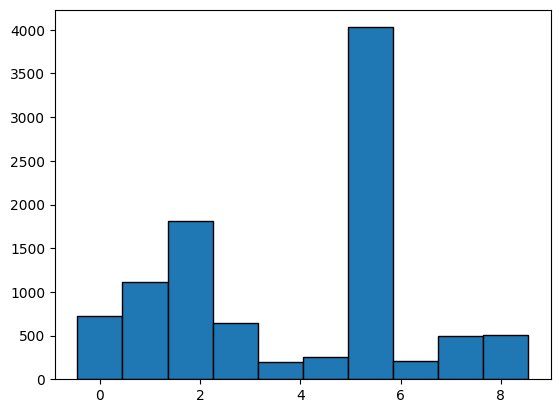

In [5]:
print("\nEvaluating the model before training:")

# Load Pretrained Model
model = create_model(model_name, pretrained=True, num_classes=10)  # CIFAR-10 has 10 classes
model = model.to(device) # Move model to GPU if available
criterion = nn.CrossEntropyLoss()

print("Model Loaded with Configuration:", model.default_cfg)
# Data Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

_, _ ,out= test(model, test_loader, criterion, device)
output=[l.detach().cpu().numpy() for l in out]
output=np.concatenate(output)
plt.hist(list(np.argmax(output,axis=1)), edgecolor='black', align='left')

- the accuracy / loss can  not be interpreted here since the classes can not be assigned.


## Finetune

lets see what happens if we train with only with a few batches..
we set 'n_batches=10'
and 
'batch_size = 64'

meaning the model sees 640 randomly drawn images from the trainigset.

In [6]:
n_batches=10

# Configuration
model_name = "vit_base_patch16_224"
batch_size = 64
epochs = 1
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


# Load Pretrained Model
model = create_model(model_name, pretrained=True, num_classes=10)  # surprise surprise CIFAR-10 has 10 classes
model = model.to(device)
print("Model Loaded with Configuration:", model.default_cfg)


# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Data Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device,n_batches=n_batches-1)
    test_loss, test_acc,_ = test(model, test_loader, criterion, device)

print(f"Fine-tuning with {n_batches} batches completed!")

Device: cuda
Model Loaded with Configuration: {'url': '', 'hf_hub_id': 'timm/vit_base_patch16_224.augreg2_in21k_ft_in1k', 'architecture': 'vit_base_patch16_224', 'tag': 'augreg2_in21k_ft_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'fixed_input_size': True, 'interpolation': 'bicubic', 'crop_pct': 0.9, 'crop_mode': 'center', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'num_classes': 1000, 'pool_size': None, 'first_conv': 'patch_embed.proj', 'classifier': 'head'}
Epoch 1/1
Batch 1/782 completed.
Batch 2/782 completed.
Batch 3/782 completed.
Batch 4/782 completed.
Batch 5/782 completed.
Batch 6/782 completed.
Batch 7/782 completed.
Batch 8/782 completed.
Batch 9/782 completed.
Batch 10/782 completed.
Train Loss: 0.0120, Accuracy: 71.41%
Test Loss: 0.2776, Accuracy: 91.25%
Fine-tuning with 10 batches completed!



- just seeing 10* 640 images (with random rotations)  once was enough to 

## Finetune 2
If you want you can finetune the model furteher
- adjust epochs
- track loss
! this will take a bit longer..

In [ ]:
# Configuration
model_name = "vit_base_patch16_224"
batch_size = 64
epochs = 20
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


# Load Pretrained Model
model = create_model(model_name, pretrained=True, num_classes=10)  # surprise surprise CIFAR-10 has 10 classes
model = model.to(device)
print("Model Loaded with Configuration:", model.default_cfg)


# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Data Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device,n_batches=None)
    test_loss, test_acc,_ = test(model, test_loader, criterion, device)

print("Fine-tuning completed!")

Device: cuda
Model Loaded with Configuration: {'url': '', 'hf_hub_id': 'timm/vit_base_patch16_224.augreg2_in21k_ft_in1k', 'architecture': 'vit_base_patch16_224', 'tag': 'augreg2_in21k_ft_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'fixed_input_size': True, 'interpolation': 'bicubic', 'crop_pct': 0.9, 'crop_mode': 'center', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'num_classes': 1000, 'pool_size': None, 'first_conv': 'patch_embed.proj', 'classifier': 'head'}
Epoch 1/20
Batch 1/782 completed.
Batch 2/782 completed.
Batch 3/782 completed.
Batch 4/782 completed.
Batch 5/782 completed.
Batch 6/782 completed.
Batch 7/782 completed.
Batch 8/782 completed.
Batch 9/782 completed.
Batch 10/782 completed.
Batch 11/782 completed.
Batch 12/782 completed.
Batch 13/782 completed.
Batch 14/782 completed.
Batch 15/782 completed.
Batch 16/782 completed.
Batch 17/782 completed.
Batch 18/782 completed.
Batch 19/782 completed.
Batch 20/782 completed.
Batch 21/782 completed.
Batch 22/7

# laod your own dataset

Pfad_zu_deinem_dataset/
    train/
        class_1/
            image1.jpg
            image2.jpg
            ...
        class_2/
            image1.jpg
            image2.jpg
            ...

    validation/
        class_1/
            image1.jpg
            image2.jpg
            ...
        class_2/
            image1.jpg
            image2.jpg
            ...
    test/
        class_1/
            image1.jpg
            image2.jpg
            ...
        class_2/
            image1.jpg
            image2.jpg
            ...

In [ ]:
# Load dataset using ImageFolder
import os

DATA_DIR = "./data"

train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "train"), transform=transform_train)

validation_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "test"), transform=transform_test)
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "test"), transform=transform_test)
